Testing a new way of fitting and plotting the emission lines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
line_tab = Table.read('linsky_lines.tsv', format ='ascii')
#line_tab

In [3]:
lines = line_tab['Wavelength']*10
#len(lines[lines > 1100])

In [4]:
t1data = Table.read('../../common/quicksaves/2MASS-J23062928-0502285_basic.ecsv')

In [5]:
w, f , e = np.array(t1data['WAVELENGTH']), np.array(t1data['FLUX']), np.array(t1data['ERROR'])

In [21]:
cos_cut = (w > 1100) & (w < 1210) | (w > 1220) & (w < 1780) 
w, f, e = w[cos_cut], f[cos_cut], e[cos_cut]

In [22]:
line_data = [1176., 1206.51, 1218.344, 1238.821, 1242.804,
       1334.532, 1335.708, 1351.657,
       1355.598, 1371.292, 1393.755, 1401.156, 1402.77 , 1548.195,
       1550.77 , 1561.   , 1643.   , 1666.153, 1670.787, 2795.523, 2802.697] #lines for which data exists

In [23]:
ciii_1175 = [1174.93,1175.26,1175.59,1175.71,1175.99, 1176.37]
model_lines = [1206.51, 1218.344, 1238.821, 1242.804,
       1334.532, 1335.708, 1351.657,
       1355.598, 1371.292, 1393.755, 1401.156, 1402.77 , 1548.195, 1550.77 , 1561.   , 1643.   , 1666.153, 1670.787]#, 2795.523, 2802.697]


In [34]:
fitter = fitting.SLSQPLSQFitter()
#fitter = fitting.LevMarLSQFitter()

smooth = 5
f1 = convolve(f,Box1DKernel(smooth))
e1 = convolve(e,Box1DKernel(smooth))/smooth**0.5


gg_init = models.Polynomial1D(2)
dv = -56.3*u.km/u.s

for line in ciii_1175:
    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
    gg_init += models.Gaussian1D(1e-16, li.value,0.1)

for line in model_lines:
    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
    gg_init += models.Gaussian1D(1e-16, li.value,0.1)    
    
gg_fit = fitter(gg_init, w, f1, weights=1/e1, maxiter=10000)

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/astropy/modeling/statistic.py:42: RuntimeWarning: invalid value encountered in multiply
  return np.sum((weights * (model_vals - measured_vals)) ** 2)


KeyboardInterrupt: 

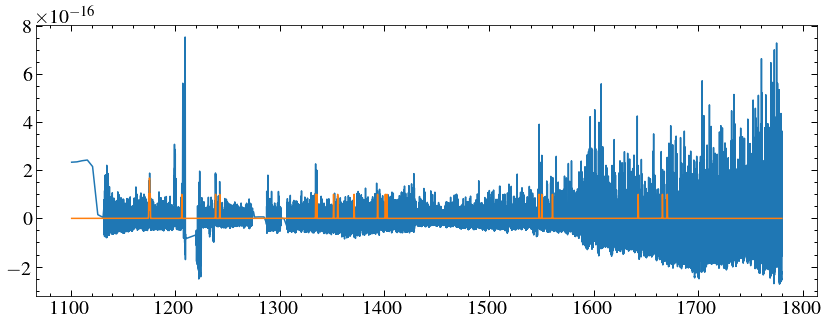

In [30]:
plt.plot(w,f1)
plt.plot(w, gg_fit(w))
#plt.xlim(1750, 1800)

(-1e-17, 2e-16)

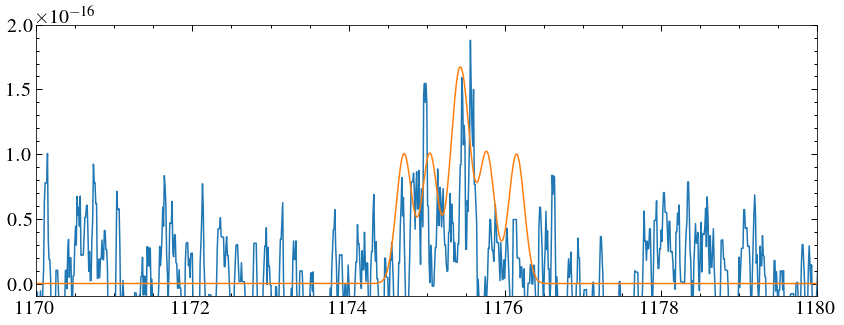

In [32]:
plt.plot(w,f1)
plt.plot(w, gg_fit(w))
plt.xlim(1170, 1180)
plt.ylim(-0.1e-16, 2e-16)

In [33]:
gg_fit

<CompoundModel(c0_0=0., c1_0=0., c2_0=0., amplitude_1=0., mean_1=1174.70935216, stddev_1=0.1, amplitude_2=0., mean_2=1175.03929018, stddev_2=0.1, amplitude_3=0., mean_3=1175.36922821, stddev_3=0.1, amplitude_4=0., mean_4=1175.48920568, stddev_4=0.1, amplitude_5=0., mean_5=1175.76915309, stddev_5=0.1, amplitude_6=0., mean_6=1176.14908173, stddev_6=0.1, amplitude_7=0., mean_7=1206.28342154, stddev_7=0.1, amplitude_8=0., mean_8=1218.11519916, stddev_8=0.1, amplitude_9=0., mean_9=1238.58835365, stddev_9=0.1, amplitude_10=0., mean_10=1242.57060565, stddev_10=0.1, amplitude_11=0., mean_11=1334.28137945, stddev_11=0.1, amplitude_12=0., mean_12=1335.4571586, stddev_12=0.1, amplitude_13=0., mean_13=1351.40316343, stddev_13=0.1, amplitude_14=0., mean_14=1355.34342332, stddev_14=0.1, amplitude_15=0., mean_15=1371.03447604, stddev_15=0.1, amplitude_16=0., mean_16=1393.49325757, stddev_16=0.1, amplitude_17=0., mean_17=1400.89286769, stddev_17=0.1, amplitude_18=0., mean_18=1402.50656458, stddev_18=0